In [ ]:
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


# Processamento de Dados

Função: *preprocess_dataset*

Esta função carrega e pré-processa um dataset para ser utilizado numa rede neural CNN, dividindo-o em conjuntos de treino, teste e validação, normalizando os dados.

In [ ]:
def preprocess_dataset(dataset_path, train_folds, test_folds, val_folds, num_classes=10):
    # Carregar o dataset
    with open(dataset_path, 'rb') as file:
        dataset_cnn = pickle.load(file)

    # Converter para array numpy
    dataset_cnn = np.array(dataset_cnn)
    print(f"Shape do dataset: {dataset_cnn.shape}")

    # Inicializar listas necessárias para o treino, teste e validação
    X_train, y_train = [], []
    X_test, y_test = [], []
    X_val, y_val = [], []

    # Preencher dados de treino
    for fold_idx in train_folds:
        data, labels = dataset_cnn[fold_idx]
        X_train.extend(data)
        y_train.extend(labels)

    # Preencher dados de teste
    for fold_idx in test_folds:
        data, labels = dataset_cnn[fold_idx]
        X_test.extend(data)
        y_test.extend(labels)

    # Preencher dados de validação
    for fold_idx in val_folds:
        data, labels = dataset_cnn[fold_idx]
        X_val.extend(data)
        y_val.extend(labels)

    # Converter para arrays numpy
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    X_train = np.transpose(X_train, (0, 2, 3, 1))
    X_test = np.transpose(X_test, (0, 2, 3, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 1))

    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    X_val = X_val.astype(float)

    means = X_train.mean(axis=(0, 1, 2), keepdims=True)
    stds = X_train.std(axis=(0, 1, 2), keepdims=True)

    # Normalizar cada conjunto usando as estatísticas do conjunto de treino
    X_train = (X_train - means) / stds
    X_test = (X_test - means) / stds
    X_val = (X_val - means) / stds

    # Codificar labels como inteiros
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    y_val = encoder.transform(y_val)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print(f"Shape de X_val: {X_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val

Função: *preprocess_dataset_aug* 

Esta função carrega e pré-processa o dataset para ser utilizado numa rede neural CNN, com a opção de aplicar aumentos de dados leves, como deslocamento temporal e masking.

In [ ]:
# Define funções de data augmnentation para a CNN
def time_shift(sample, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(sample, shift, axis=1)

def frequency_masking(sample, max_mask_size=2):
    freq_mask = np.random.randint(1, max_mask_size)
    freq_start = np.random.randint(0, sample.shape[0] - freq_mask)
    sample[freq_start:freq_start + freq_mask, :, :] = 0
    return sample

def time_masking(sample, max_mask_size=15):
    time_mask = np.random.randint(1, min(max_mask_size, sample.shape[1]))
    time_start = np.random.randint(0, sample.shape[1] - time_mask + 1)
    sample[:, time_start:time_start + time_mask, :] = 0
    return sample

def add_noise(sample, noise_level=0.005):
    noise = np.random.normal(0, noise_level, sample.shape)
    return sample + noise

def preprocess_dataset_aug(dataset_path, train_folds, test_folds, val_folds, num_classes=10, augment=True):
    # Carregar o dataset
    with open(dataset_path, 'rb') as file:
        dataset_cnn = pickle.load(file)

    # Converter para array numpy 
    dataset_cnn = np.array(dataset_cnn)
    print(f"Shape do dataset: {dataset_cnn.shape}")

    # Inicializar listas necessárias para o treino, teste e validação
    X_train, y_train = [], []
    X_test, y_test = [], []
    X_val, y_val = [], []

    # Preencher dados de treino
    for fold_idx in train_folds:
        data, labels = dataset_cnn[fold_idx]
        for sample, label in zip(data, labels):
            X_train.append(sample)  
            y_train.append(label)

            # Aplicar time_shift
            sample_time_shift = time_shift(sample)
            X_train.append(sample_time_shift)  
            y_train.append(label)

            # Aplicar frequency_masking
            sample_frequency_masking = frequency_masking(sample)
            X_train.append(sample_frequency_masking)  
            y_train.append(label)

            # Aplicar time_masking
            sample_time_masking = time_masking(sample)
            X_train.append(sample_time_masking)  
            y_train.append(label)

            # Aplicar noise
            sample_noise = add_noise(sample)
            X_train.append(sample_noise)  
            y_train.append(label)

    # Preencher dados de teste
    for fold_idx in test_folds:
        data, labels = dataset_cnn[fold_idx]
        X_test.extend(data)
        y_test.extend(labels)

    # Preencher dados de validação
    for fold_idx in val_folds:
        data, labels = dataset_cnn[fold_idx]
        X_val.extend(data)
        y_val.extend(labels)

    # Converter para arrays numpy
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Transpor dimensões para samples, height, width, channels
    X_train = np.transpose(X_train, (0, 2, 3, 1))
    X_test = np.transpose(X_test, (0, 2, 3, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 1))

    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    X_val = X_val.astype(float)

    means = X_train.mean(axis=(0, 1, 2), keepdims=True)  
    stds = X_train.std(axis=(0, 1, 2), keepdims=True)   

    # Normalizar cada conjunto utilizando as estatísticas do conjunto de treino
    X_train = (X_train - means) / stds
    X_test = (X_test - means) / stds
    X_val = (X_val - means) / stds

    # Codificar labels como inteiros
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    y_val = encoder.transform(y_val)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print(f"Shape de X_val: {X_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val

Função: *preprocess_dataset_aug_min* 

Esta função carrega, pré-processa e aplica técnicas de data augmentation ao conjunto de dados, com o objetivo de preparar os dados para o treino de uma rede neural CNN. A função trata de forma especial as classes minoritárias, com o intuito de balancear a distribuição das classes no conjunto de dados.

In [ ]:
# Definir funções de data augmentation para a CNN
def time_shift(sample, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(sample, shift, axis=1)

def frequency_masking(sample, max_mask_size=2):
    freq_mask = np.random.randint(1, max_mask_size)
    freq_start = np.random.randint(0, sample.shape[0] - freq_mask)
    sample[freq_start:freq_start + freq_mask, :, :] = 0
    return sample

def time_masking(sample, max_mask_size=15):
    time_mask = np.random.randint(1, min(max_mask_size, sample.shape[1]))
    time_start = np.random.randint(0, sample.shape[1] - time_mask + 1)
    sample[:, time_start:time_start + time_mask, :] = 0
    return sample

def add_noise(sample, noise_level=0.005):
    noise = np.random.normal(0, noise_level, sample.shape)
    return sample + noise

# Função principal para carregar e processar o dataset com data augmentation 
def preprocess_dataset_aug_min(dataset_path, train_folds, test_folds, val_folds, minor_classes, num_classes=10):
    with open(dataset_path, 'rb') as file:
        dataset_cnn = pickle.load(file)
        
    dataset_cnn = np.array(dataset_cnn)
    print(f"Shape do dataset: {dataset_cnn.shape}")

    X_train, y_train = [], []
    X_test, y_test = [], []
    X_val, y_val = [], []
    
    augmentation_factor_minor = 4  # Número de augmentations para classes minoritárias
    augmentation_factor_general = 2  # Número de augmentations para classes gerais

    for fold_idx in train_folds:
        data, labels = dataset_cnn[fold_idx]
        for sample, label in zip(data, labels):
            X_train.append(sample)
            y_train.append(label)

            # Determinar fator de augmentation dependendo se a classe é minoritária
            augmentation_factor = augmentation_factor_minor if label in minor_classes else augmentation_factor_general
            
            # Aplicar augmentation
            for _ in range(augmentation_factor):
                augmented_sample = sample.copy()
                
                shift = time_shift(augmented_sample)
                X_train.append(shift)
                y_train.append(label)
                
                frequency = frequency_masking(augmented_sample)
                X_train.append(frequency)
                y_train.append(label)

                masking = time_masking(augmented_sample)
                X_train.append(masking)
                y_train.append(label)
            
                noise = add_noise(augmented_sample)
                X_train.append(noise)
                y_train.append(label)

    # Processar conjunto de teste
    for fold_idx in test_folds:
        data, labels = dataset_cnn[fold_idx]
        X_test.extend(data)
        y_test.extend(labels)

    # Processar conjunto de validação
    for fold_idx in val_folds:
        data, labels = dataset_cnn[fold_idx]
        X_val.extend(data)
        y_val.extend(labels)

    # Converter para numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    X_train = np.transpose(X_train, (0, 2, 3, 1))
    X_test = np.transpose(X_test, (0, 2, 3, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 1))

    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    X_val = X_val.astype(float)
    
    means = X_train.mean(axis=(0, 1, 2), keepdims=True)  
    stds = X_train.std(axis=(0, 1, 2), keepdims=True)    

    # Normalizar cada conjunto utilizando as estatísticas do conjunto de treino
    X_train = (X_train - means) / stds
    X_test = (X_test - means) / stds
    X_val = (X_val - means) / stds

    # Codificar labels como inteiros
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    y_val = encoder.transform(y_val)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print(f"Shape de X_val: {X_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val

# CNNs

Função CNN 
- Entrada: Aceita dados no formato especificado por input_shape.
- Camadas convolucionais: 
     - 3 camadas convolucionais com 32, 64 e 128 filtros, respetivamente.
     - Cada camada utiliza filtros de tamanho (3x3) e ativação ReLU.
-  Camada de achatamento: Transforma a saída convolucional num vetor plano para entrada na camada densa.
- Camada densa: Uma camada com 128 neurónios e ativação ReLU.
- Camada de saída: Realiza a classificação em num_classes usando ativação softmax.

In [6]:
def create_cnn(input_shape, num_classes):
    model = models.Sequential()
    # Camada convolucional 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Camada convolucional 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # Camada convolucional 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    # Camada densa 
    model.add(layers.Dense(128, activation='relu'))
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Função CNN2

- Entrada: Aceita dados no formato especificado por input_shape.
- Camadas convolucionais:
     - 3 camadas convolucionais com 32, 64 e 128 filtros, respetivamente.
     - Cada camada utiliza filtros de tamanho (3x3), ativação ReLU, regularização L2 (para reduzir overfitting), e padding "same" para preservar as dimensões espaciais.
  - Inclui BatchNormalization após cada camada para estabilizar e acelerar o treino.
- Camada de achatamento: Transforma a saída convolucional num vetor plano para entrada nas camadas densas.
- Camada densa: Uma camada com 128 neurónios, ativação ReLU, regularização L2 e Dropout (50%) para prevenir overfitting.
- Camada de saída: Realiza a classificação em num_classes usando ativação softmax.

In [ ]:
def create_cnn2(input_shape, num_classes):
    model = models.Sequential()
    # Camada convolucional 1 com BatchNormalization 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,kernel_regularizer=regularizers.l2(0.001), padding="same"))
    model.add(layers.BatchNormalization())
    # Camada convolucional 2 com BatchNormalization 
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding="same"))
    model.add(layers.BatchNormalization())
    # Camada convolucional 3 com BatchNormalization 
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding="same"))
    model.add(layers.BatchNormalization())
    # Flatten antes de passar para as camadas densas
    model.add(layers.Flatten())
    # Camada densa com dropout
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Função CNN3

- Entrada: Estrutura concebida para processar dados com o formato definido em input_shape.
- Camadas convolucionais:
  - 3 camadas convolucionais, todas com 32 filtros de tamanho (3x3).
  - Utilizam ativação ReLU para introduzir não-linearidade.
- Camada de achatamento: A saída convolucional é transformada num vetor plano para servir como entrada na camada densa.
- Camada densa:
  - Inclui 16 neurónios com ativação ReLU.
  - Dropout com taxa de 50% para reduzir o risco de overfitting.
- Camada de saída: Realiza a classificação em num_classes usando ativação softmax.

In [7]:
def create_cnn3(input_shape, num_classes):
    model = models.Sequential()
    # Camada convolucional 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Camada convolucional 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    # Camada convolucional 3
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    # Camada densa 
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Função CNN4
- Entrada: Aceita dados no formato especificado por input_shape.
- Camadas convolucionais:
    - Três camadas convolucionais:
      - Filtros de tamanho (3x3) com ativação ReLU.
      - Número crescente de filtros: 32, 64 e 128 respetivamente, aumentando a profundidade do modelo.
      - Regularização L2 aplicada a todos os filtros para evitar overfitting.
      - BatchNormalization após cada camada para estabilizar os gradientes e melhorar a eficiência do treino.
- Camada de achatamento: Transforma os mapas de características em vetores planos para uso em camadas densas.
- Camada densa:
  - Uma camada com 128 neurónios e ativação ReLU.
  - Inclui Dropout com uma taxa de 50% para mitigar o overfitting.
- Camada de saída: Classificação em num_classes com ativação softmax.

In [ ]:
def create_cnn4(input_shape, num_classes):
    model = models.Sequential()
    # Camada convolucional 1 com Batch Normalization 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    # Camada convolucional 2 com Batch Normalization  
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    # Camada convolucional 3 com Batch Normalization 
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
   # Camada densa 
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))  # Dropout de 50%
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Função *CNN_BatchNorm*

Semelhante à função CNN, acrescentando-lhe Batch Normalization em cada camada e dropout de 50% na camada de saída.

In [9]:
def create_cnn_batchNorm(input_shape, num_classes):
    model = models.Sequential()
    # Camada convolucional 1
    model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())  
    # Camada convolucional 2
    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())  
    # Camada convolucional 3
    model.add(layers.Conv2D(128, (3, 3)))
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())  
    model.add(layers.Flatten())
    # Camada densa 
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())  
    model.add(layers.Dropout(0.5)) 
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

Função CNN5
- Entrada: A rede aceita dados com o formato especificado por input_shape
- Camadas convolucionais:
  - Camada 1:
    - 16 filtros com tamanho (3, 3) e ativação ReLU.
    - Regularização L2 aplicada para evitar sobreajuste.
    - BatchNormalization para normalizar as ativações 
    - Dropout de 20% 
  - Camada 2:
    - 32 filtros com tamanho (3, 3) e ativação ReLU.
    - Regularização L2 aplicada.
    - BatchNormalization para normalizar as ativações
    - Dropout de 20% 
  - Camada 3:
    - 64 filtros com tamanho (3, 3) e ativação ReLU.
    - Regularização L2 para manter o modelo robusto.
    - BatchNormalization para normalizar as ativações
    - Dropout de 20% 
- Camada de achatamento (Flatten): Transforma os mapas de características (saída das camadas convolucionais) num vetor unidimensional para ser processado pelas camadas densas.
- Camada densa:
  - 64 neurónios com ativação ReLU.
  - Regularização L2 aplicada para evitar overfitting.
  - BatchNormalization para normalizar as ativações
  - Dropout de 20% para melhorar a generalização do modelo e evitar overfitting.
- Camada de saída: Realiza a classificação em num_classes usando ativação softmax.

In [10]:
def create_cnn5(input_shape, num_classes):
    model = models.Sequential()
    # Camadas convolucionais com Dropout e BatchNormalization
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Funções de Compile

In [11]:
def compile_cnn(model):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()   
    return model

In [12]:
def compile_cnn_SGD(model, learning_rate=0.01, momentum=0.9, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    model.summary()
    return model

Funções de Train

In [13]:
def train_cnn(model, X_train, y_train, X_val, y_val, epochs, batch_size, class_names=None):
    history = model.fit(X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val)
    )
    return history

In [14]:
def train_cnn4(model, X_train, y_train, X_val, y_val, epochs, batch_size, class_names=None):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history =  model.fit(X_train, y_train,  
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )
    return history

Função de Plot de Resultados

In [15]:
def plot_training_history_and_evaluate(history, model, X_test, y_test):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()

    scores = model.evaluate(X_test, y_test)
    print("Test accuracy:", scores[1])

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  
    y_true = y_test  

    cm = confusion_matrix(y_true, y_pred_classes)
    class_names= ['0','1','2','3','4','5','6','7','8','9']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

Ao longo deste projeto, foram utilizados dois tipos de estratégias de Data Augmentation, nomeadamente:

*Data Aug:*
\
Esta abordagem consistiu em aumentar o volume total de dados de forma uniforme, aplicando transformações nos dados originais para enriquecer o conjunto de treino. O objetivo era gerar variações que ajudassem os modelos a generalizar melhor.

*Data Aug para class min:*
\
Esta estratégia foi desenvolvida para abordar o problema de desbalanceamento entre classes. O aumento foi direcionado principalmente para as classes minoritárias, gerando dados adicionais para equilibrar a proporção entre elas e as classes maioritarias.

# Análise dos Resultados Obtidos

# *CNN: A Rede Original*
A arquitetura CNN foi a base das experiências. Esta rede serviu como ponto de partida para os testes, apresentando os seguintes resultados:

- **Overfitting Evidente:** A CNN teve uma performance muito boa no conjunto de treino, no entanto as métricas no conjunto de validação foram significativamente inferiores.

# *CNN_BatchNorm: Modificação com Batch Normalization e Dropout*

A CNN_BatchNorm foi uma modificação direta da CNN original, com as seguintes melhorias:

- **Batch Normalization**: Adicionado após cada camada convolucional e na camada densa, com o objetivo de estabilizar a aprendizagem do modelo e acelerar a convergência.
- **Dropout (50%)**: Aplicado à camada densa antes da saída, para combater o overfitting.

Apesar das melhorias, a CNN_BatchNorm também sofreu overfitting. Contudo mostrou-se relativamente melhor em termos de validação, quando comparada à CNN original.

Embora a CNN_BatchNorm tenha oferecido uma melhoria em relação à CNN original, ambas as arquiteturas demonstraram overfitting, sugerindo que as modificações aplicadas não foram suficientes para melhorar significativamente a generalização dos modelos.


| Rede  | Coeficientes | Data | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
|----------|----------|----------|----------|----------|----------|----------|
| CNN  | 13 | Data Normal  | 0.0557 | 0.9821 | 3.4411 | 0.5980
| CNN  | 13 | Data Aug | 0.0545 | 0.9886 | 7.3363 | 0.5012
| CNN | 13 | Data Aug para class min | 0.0617 | 0.9868 | 8.9746 | 0.5490
| CNN_BatchNorm  | 13 | Data Normal  | 0.0686 | 0.9802 | 2.0097 | 0.5919
| CNN_BatchNorm  | 13 | Data Aug | 0.1350 | 0.9558 | 2.9172 | 0.5319
| CNN_BatchNorm  | 13 | Data Aug para class min | 0.1544 | 0.9482 | 3.4334 | 0.5735

Como resposta a isto, optamos por testar novas variações de redes:

- *CNN2:* Explorando o uso de padding para preservar informações espaciais ao longo das camadas convolucionais.
- *CNN4:* Incorporando callbacks, como o Early Stopping, para evitar overfitting.


# *CNN2: Foco em Padding e Regularização*

A CNN2 implementa o uso de padding="same", que mantém as dimensões espaciais da entrada ao longo das camadas convolucionais. Apesar do uso de BatchNormalization e regularização L2, o modelo demonstrou baixa capacidade de aprendizagem, com uma accuracy de apenas 10% no conjunto de teste. Este desempenho indica underfitting, sugerindo que a arquitetura não é capaz de aprender corretamente a natureza dos dados.

# *CNN4: Uso de Callbacks com Early Stopping*

A CNN4 inclui a técnica de Early Stopping, uma forma de callback que interrompe o treino quando não há mais melhorias na validação, evitando o treino excessivo e overfitting. Mesmo assim, o modelo também apresentou underfitting, com uma accuracy ligeiramente melhor do que a CNN2, mas ainda insuficiente. O desempenho limitado indica que, apesar de o Early Stopping evitar overfitting, o modelo não foi capaz de aprender adequadamente os padrões nos dados.

| Rede  | Coeficientes | Data | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
|----------|----------|----------|----------|----------|----------|----------|
| CNN2  | 13 | Data Normal  | 4.1081 | 0.1158 | 3.7142 | 0.1005
| CNN2  | 13 | Data Aug | 3.9833 | 0.1149 | 4.9531 | 0.1005
| CNN2  | 13 | Data Aug para class min | 2.3079 | 0.1150 | 2.4658 | 0.1091
| CNN4  | 13 | Data Normal  | 3.3670 | 0.1189 | 4.6778 | 0.1091
| CNN4  | 13 | Data Aug | 3.6113 | 0.1183 | 3.7309 | 0.1005
| CNN4  | 13 | Data Aug para class min | 2.8675 | 0.1331 | 2.7971 | 0.1225 |


Após observar os problemas de overfitting nas arquiteturas CNN e CNN_BatchNorm e o underfitting nas redes CNN2 e CNN4, procuramos construir modelos que encontrassem um equilíbrio entre simplicidade, capacidade de aprendizagem e robustez à generalização. Com base nisto criamos as arquiteturas: CNN3 e CNN5.


# *CNN3: Uma Arquitetura Simples*
A CNN3 foi projetada com o objetivo de reduzir a complexidade do modelo, minimizando o risco de overfitting observado nas redes anteriores. Esta simplicidade foi alcançada com as seguintes alterações: camadas Convolucionais Homogêneas de 32 neurónios, uma camada densa de apenas 16 neurónios e regularização com um dropout de 50%.
\
A CNN3 foca-se em evitar overfitting por meio de simplicidade e forte regularização.

# *CNN5: Capacidade Balanceada com Regularização Robusta*
A CNN5 tenta implementar um equilíbrio entre capacidade de aprendizagem e regularização, a partir de:

- Regularização L2: Aplicada em todas as camadas convolucionais e densas, reduzindo o impacto de pesos excessivos
- BatchNormalization em todas as camadas
- Dropout moderado (20%)
- Arquitetura Hierárquica:
  - Camadas convolucionais com filtros crescentes (16 e 32 neurónios)
  - Camada densa com 64 neurónios


A CNN5 aposta numa abordagem equilibrada, combinando técnicas de regularização robustas com uma arquitetura que ainda possui uma capacidade significativa de aprendizagem. Tendo também lhe sido reduzida uma camada face as restantes redes.


| Rede  | Coeficientes | Data | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
|----------|----------|----------|----------|----------|----------|----------|
| CNN3  | 13 | Data Normal  | 1.4766 |  0.4111 | 1.9499 | 0.5466
| CNN3  | 13 | Data Aug | 2.2617 | 0.1154 | 2.2461 | 0.1225
| CNN3  | 13 | Data Aug para class min | 1.2514 | 0.5120 | 2.1185 | 0.4718
| CNN5  | 13 | Data Normal  | 1.6478 | 0.9292 | 3.2734 | 0.5395
| CNN5  | 13 | Data Aug | 3.2212 | 0.7307 | 4.1819 | 0.5221
| CNN5  | 13 | Data Aug para class min | 3.0419 | 0.6496 | 3.2108 | 0.5882


Desta forma, podemos dizer que a CNN3 foi útil para explorar a simplicidade e demonstrar os limites de arquiteturas compactas, no entanto, sofreu underfitting para o caso de Data Augmentation. Já a CNN5 mostrou-se promissora, com resultados consistentes e melhorias em cenários mais desafiadores, como o aumento de dados para classes minoritárias.


Tendo por base os resultados anteriores, decidimos explorar uma nova função compile e reduzir o número de coeficientes de 13 para 8. 

As combinações que iremos explorar encontram-se marcadas na seguinte tabela com um ✅


| Rede CNN | Coeficientes | Data Utilizada |Conclusões |
|----------|----------|----------|----------|
| CNN  | 13 | Data Normal  | ❌ |
| CNN  | 13 | Data Aug | ❌ |
| CNN  | 13 | Data Aug para class min | ❌ |
| CNN2  | 13 | Data Normal | ❌ |
| CNN2  | 13 | Data Aug  | ❌ |
| CNN2  | 13 | Data Aug para class min  | ❌ |
| CNN3  | 13 | Data Normal  | ✅ |
| CNN3  | 13 | Data Aug  | ❌ |
| CNN3  | 13 | Data Aug para class min  | ✅ |
| CNN4  | 13 | Data Normal  | ❌ |
| CNN4  | 13 | Data Aug  | ❌ |
| CNN4  | 13 | Data Aug para class min  | ❌ |
| CNN_BatchNorm  | 13 | Data Normal  | ✅  |
| CNN_BatchNorm  | 13 | Data Aug  | ✅  |
| CNN_BatchNorm  | 13 | Data Aug para class min  | ❌ |
| CNN5  | 13 | Data Normal  | ✅ |
| CNN5  | 13 | Data Aug  | ❌ |
| CNN5  | 13 | Data Aug para class min  | ✅ |


# Resultados Promissores com nova função compile

A função compile_cnn_SGD tem potencial para melhorar os resultados ao usar o otimizador SGD com momentum, o que acelera a convergência e melhora a estabilidade.

| Rede CNN | Coeficientes | Data Utilizada | Train Loss | Train Accuracy | Val Loss | Val Accuracy | Gráfico Loss | Matrix de Confusão
|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| CNN3  | 13 | Data Normal  | 1.2842 | 0.5201 | 1.5028 | 0.5114 | 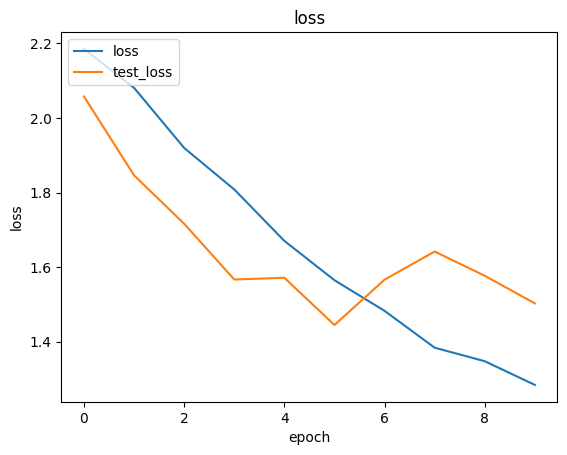 | 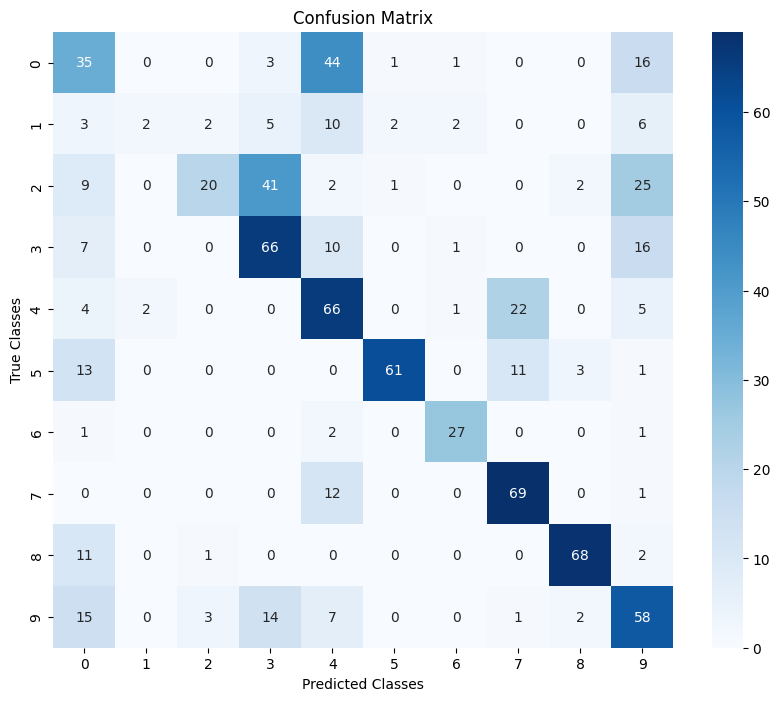 |
| CNN3  | 13 | Data Aug para class min  | 1.4728 | 0.4749 | 1.4300 | 0.5054 | 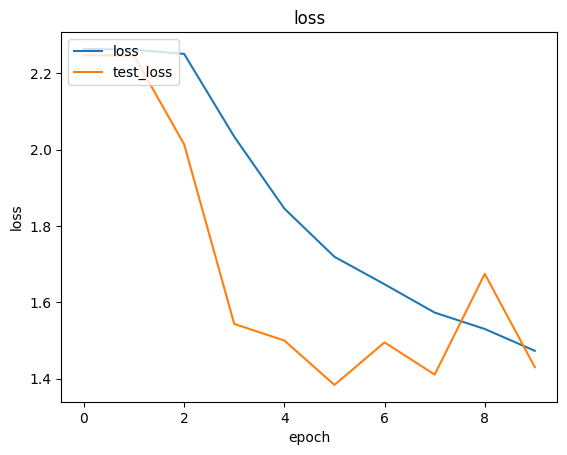 | 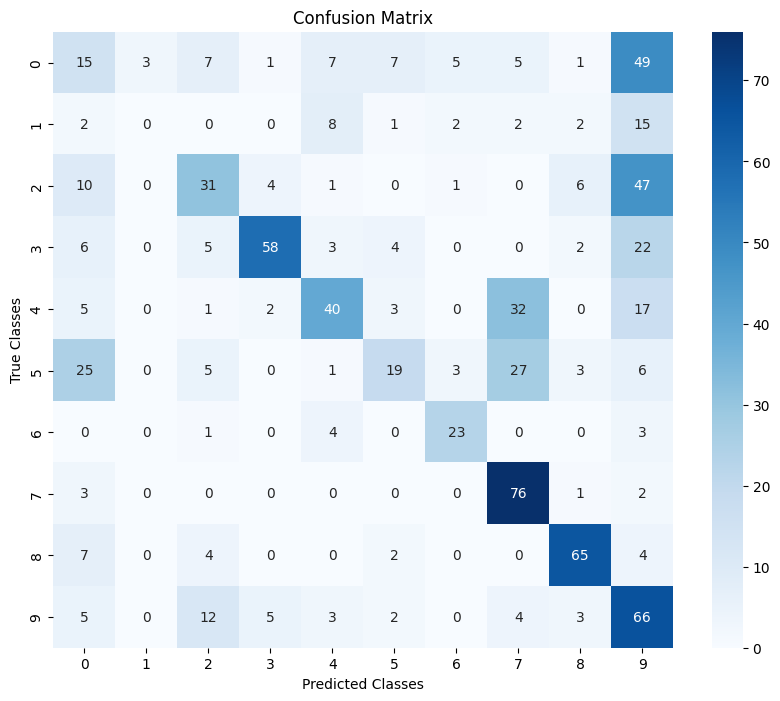 |
| CNN_BatchNorm  | 13 | Data Normal  | 0.0811 | 0.9771 | 1.5151 | 0.6368 | 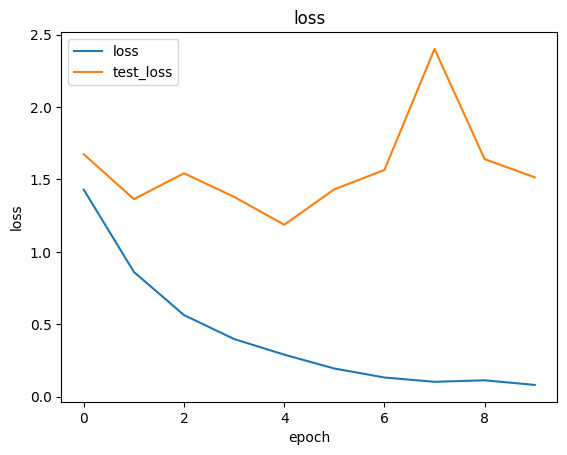 | 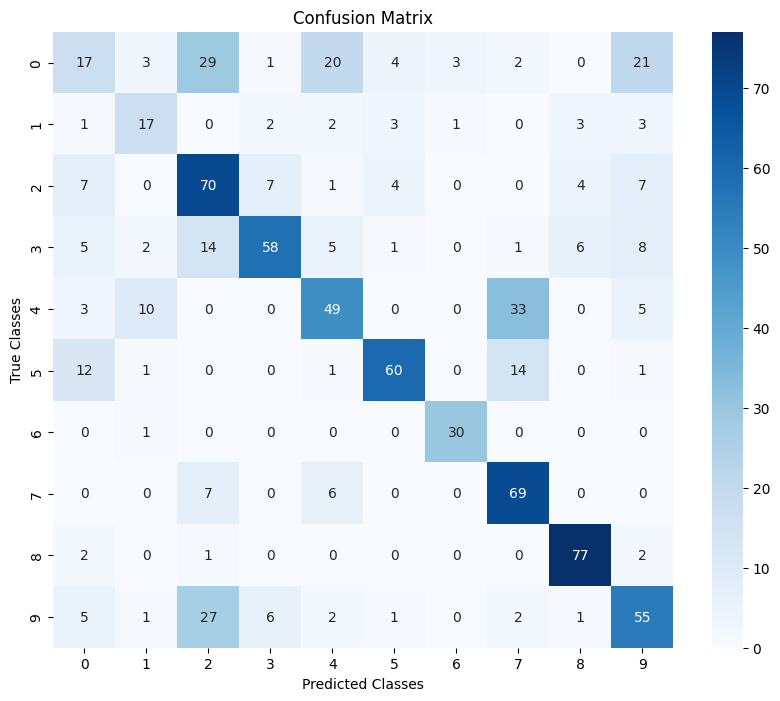 |
| CNN_BatchNorm  | 13 | Data Aug  | 0.2303 | 0.9231 | 2.3288 | 0.5269 | 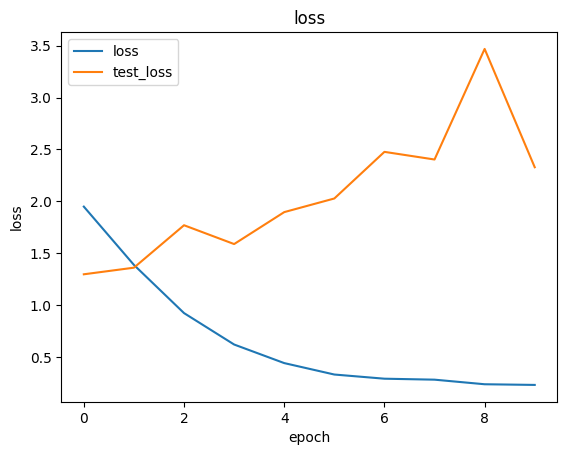 | 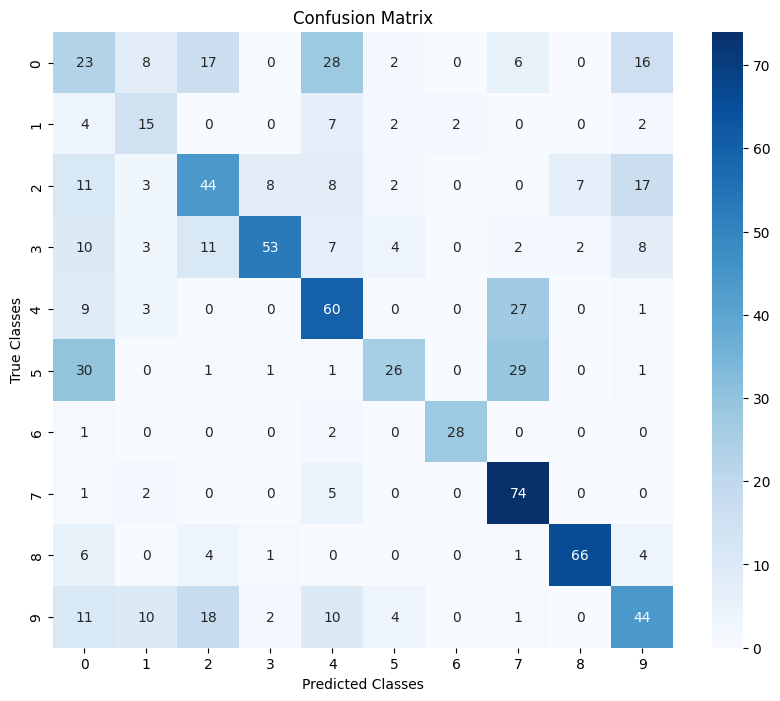 |
| CNN5  | 13 | Data Normal  | 0.6154 | 0.9791 | 2.6030 | 0.5480 | 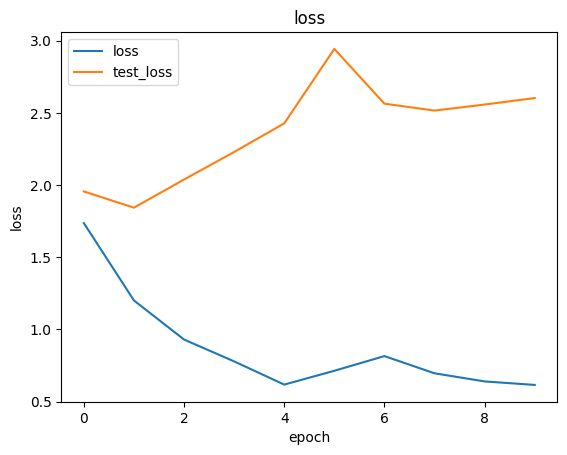 | 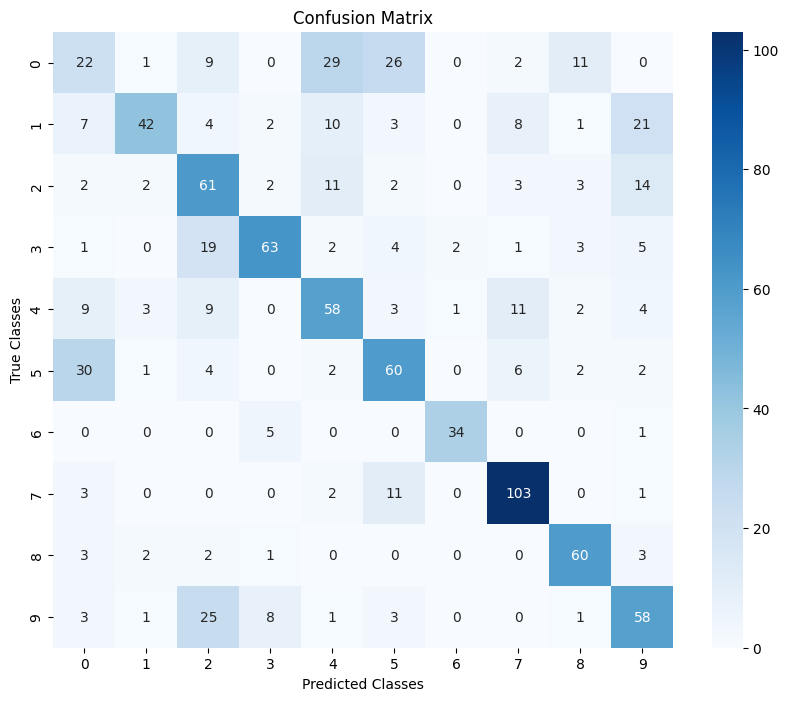
| CNN5  | 13 | Data Aug para class min | 2.0192 | 0.7999 | 3.0082 | 0.5472 | 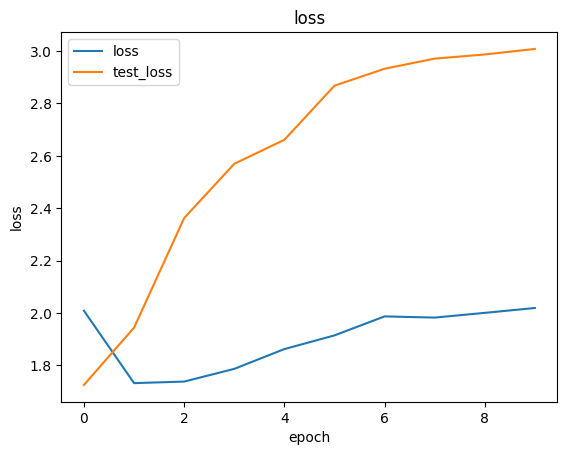 | 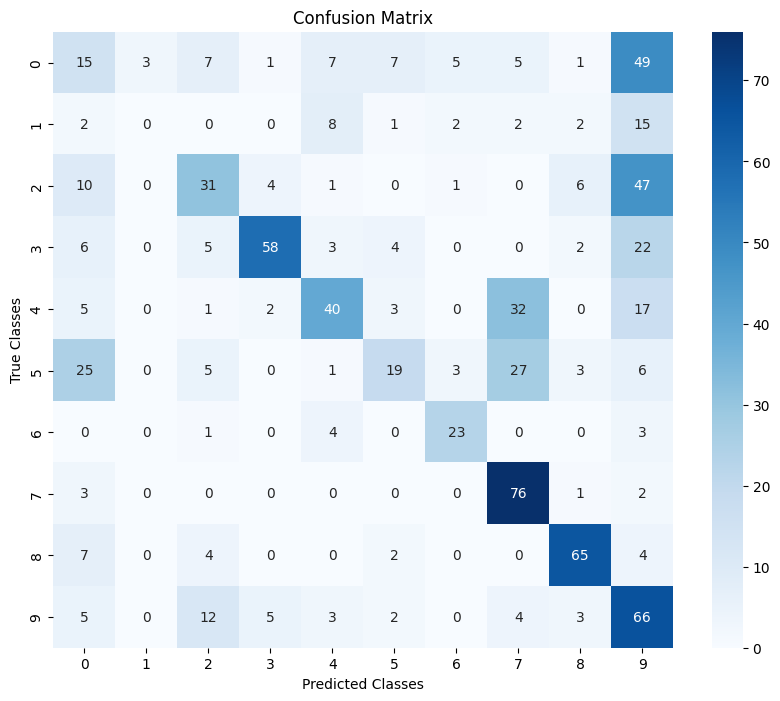 |
| CNN3  | 8 | Data Normal  | 1.1383 | 0.5745 | 1.4470 | 0.5556 | 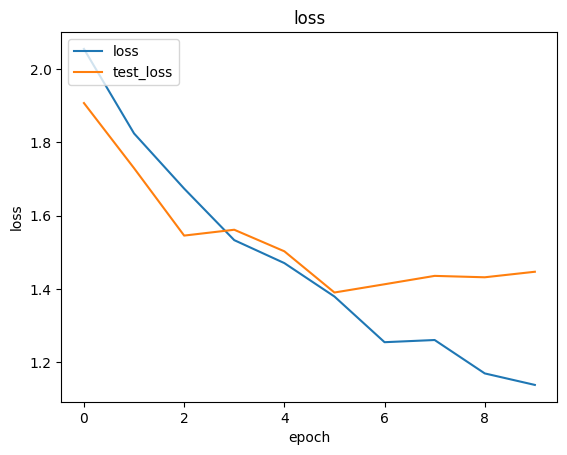 | 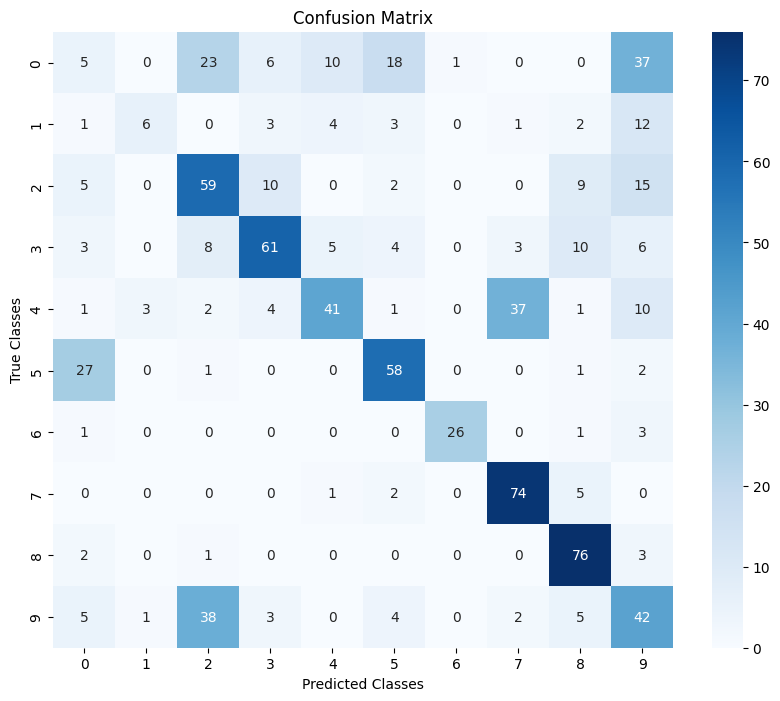 |
| CNN3  | 8 | Data Aug para class min  | 1.6502 | 0.3939 | 1.3933 | 0.4552 | 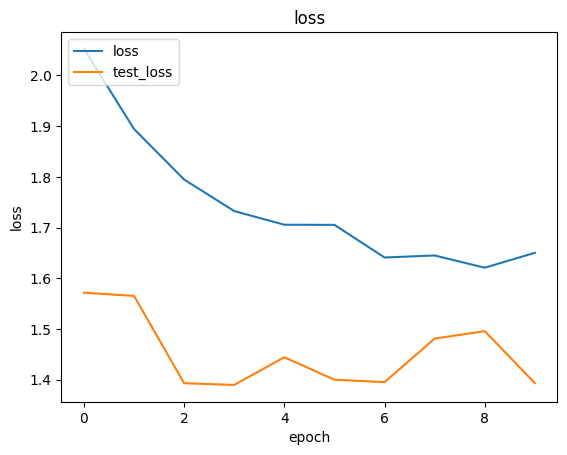 | 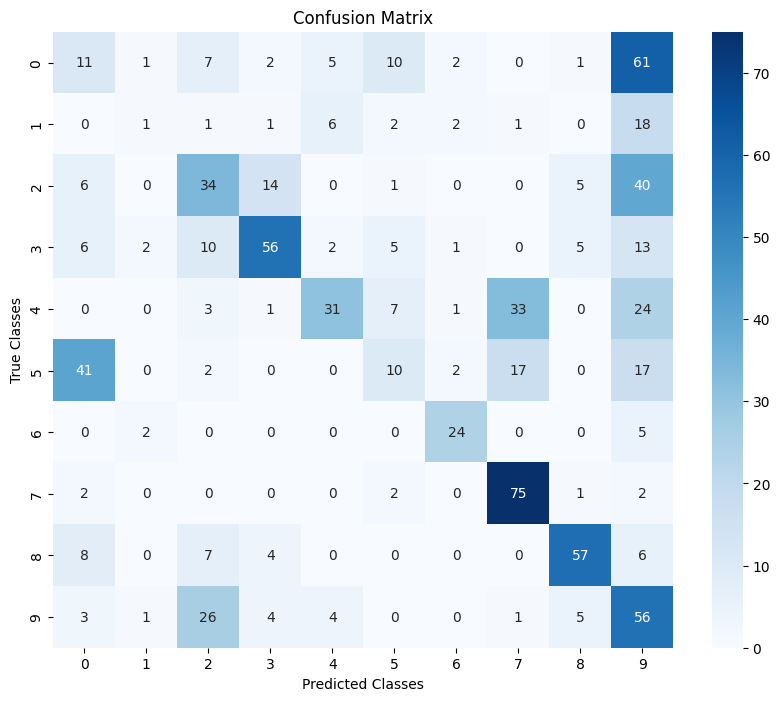 |
| CNN_BatchNorm  | 8 | Data Normal | 0.1555 | 0.9520 | 1.7964 | 0.5866 | 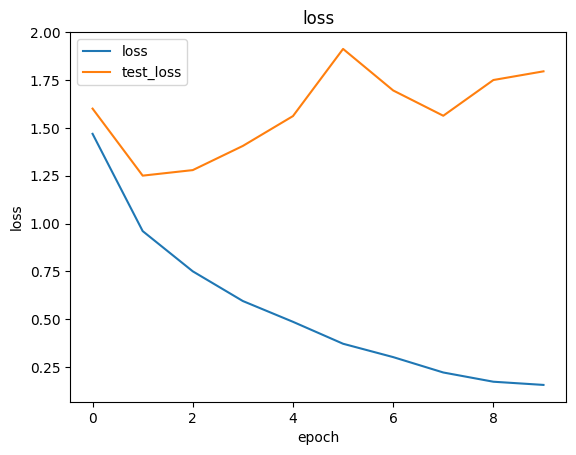 | 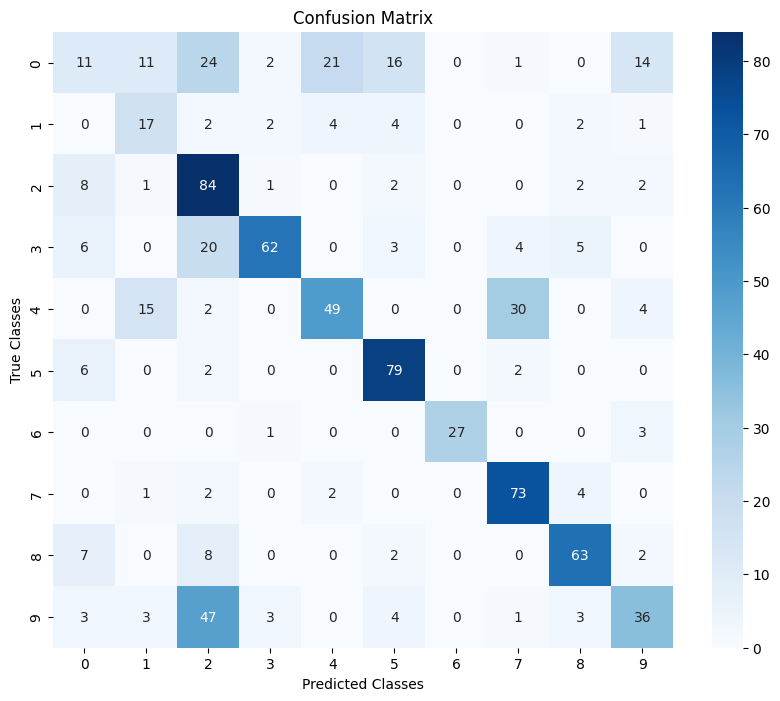 |
| CNN_BatchNorm  | 8 | Data Aug  | 0.2405 | 0.9177 | 2.5515 | 0.4839 | 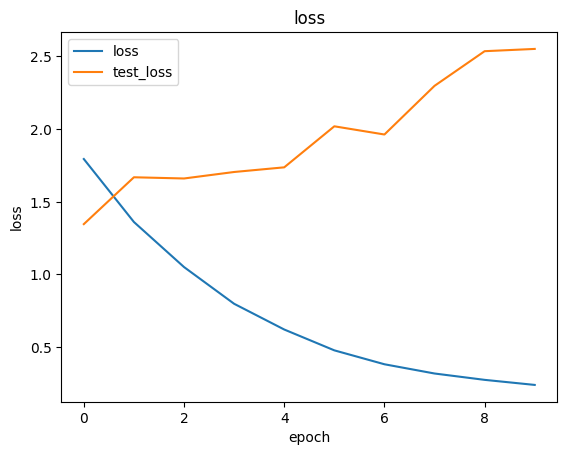 | 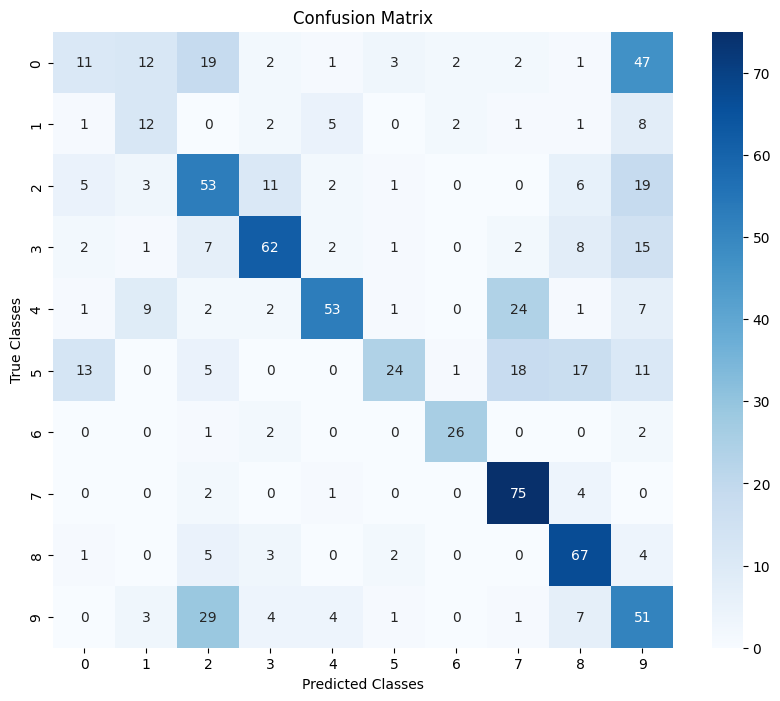 |
| CNN5  | 8 | Data Normal | 0.7408 | 0.9010 | 2.6321 | 0.5310 | 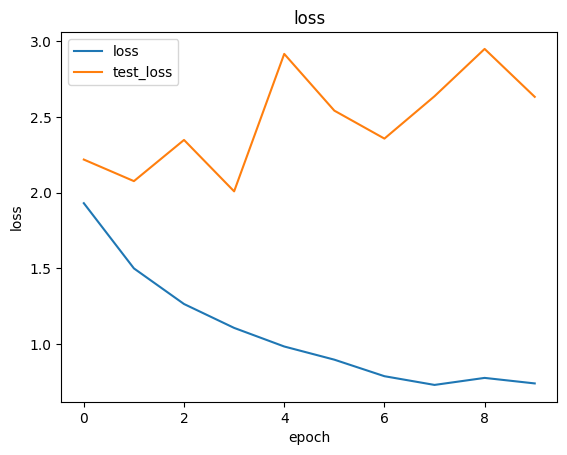 | 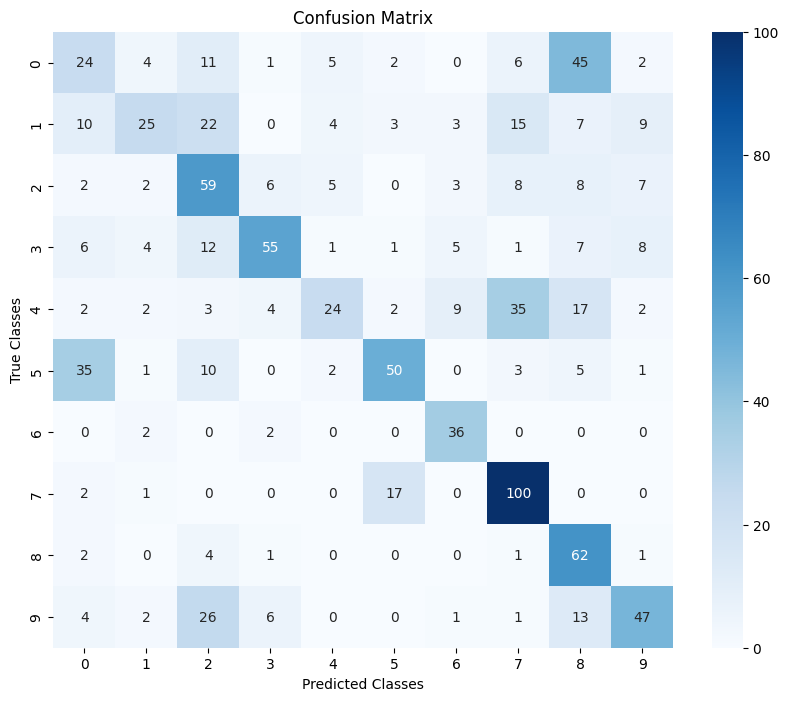 |
| CNN5  | 8 | Data Aug para class min | 1.9027 | 0.7191 | 2.6821 | 0.4958 | 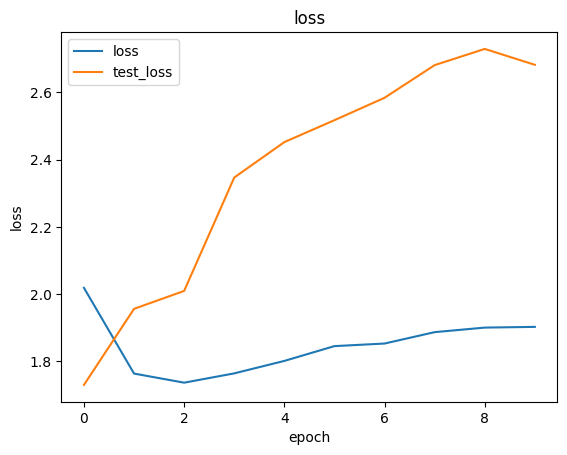 | 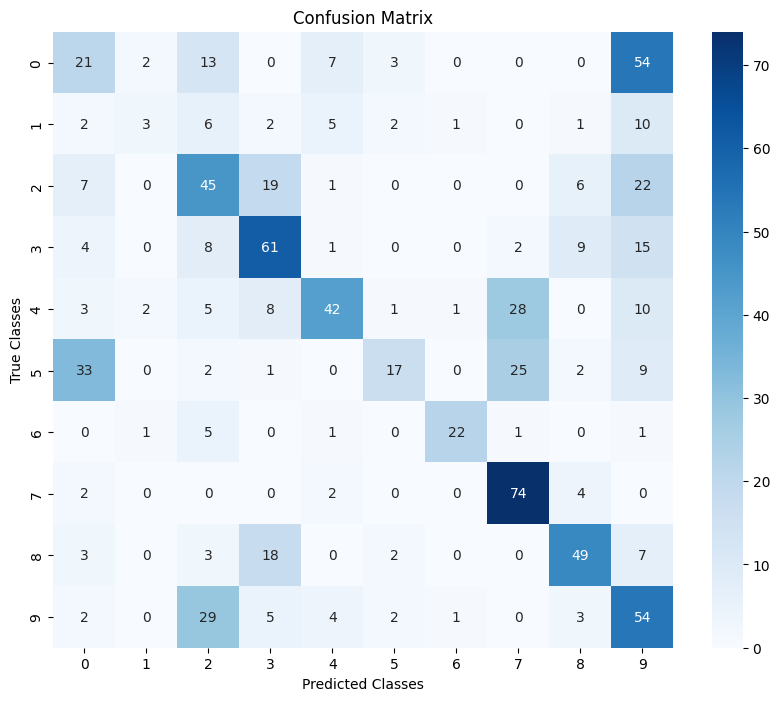 |



Os resultados indicam que a utilização da função compile_cnn_SGD com o otimizador SGD com momentum contribuiu para observar melhorias nas redes testadas.

A rede CNN_BatchNorm obteve as melhores performances em termos de precisão de treino (0.9771) com dados normais, enquanto que as redes CNN5 e CNN3 apresentaram desempenho variável com o uso de Data Augmentation, especialmente para classes minoritárias. A maior diferença entre treino e validação foi observada nas redes com Data Augmentation, sugerindo que a generalização pode ser um desafio.


Apesar de CNN_BatchNorm ter melhores resultados, decidimos fazer uma última experiência com CNN3, porque a loss continuava a mostrar uma tendência decrescente e a accuracy uma tendência crescente para 10 epochs.

Experiência final - Data Normal - CNN3 - 13 coeficientes - SGD - 25 epochs

Shape do dataset: (10, 2)
Shape de X_train: (7079, 13, 345, 3)
Shape de X_test: (816, 13, 345, 3)
Shape de X_val: (837, 13, 345, 3)
(13, 345, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 343, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 341, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 339, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 75936)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1214992   
_________________________________________________________________
dropout (Dropout)            (None, 16)    

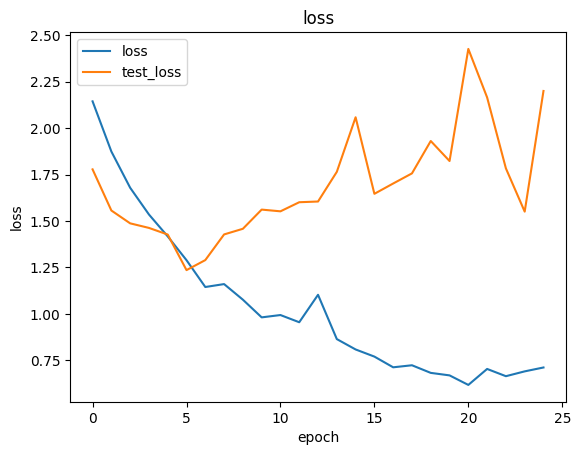

26/26 [==============================] - 0s 17ms/step - loss: 2.0778 - accuracy: 0.5551
Test accuracy: 0.5551470518112183


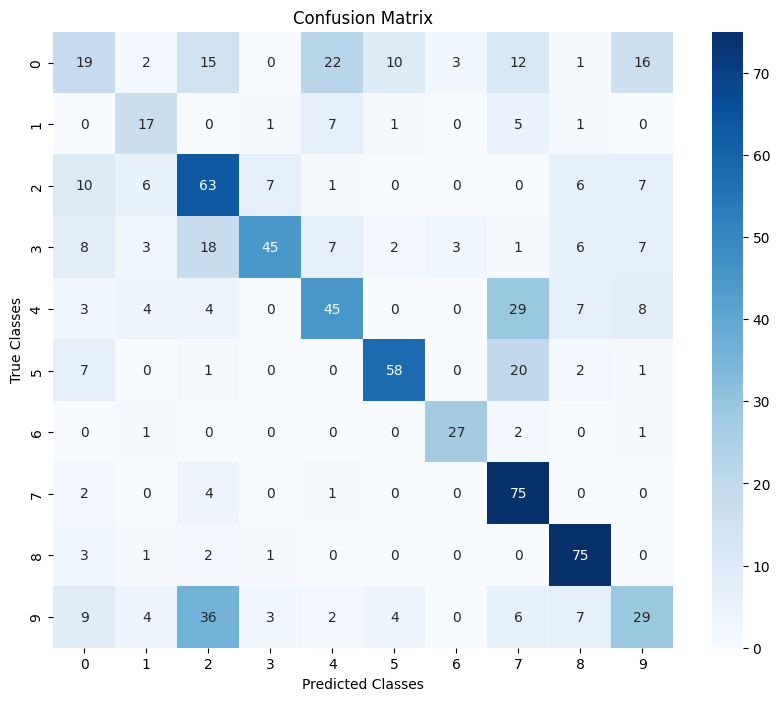


Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.19      0.24       100
           1       0.45      0.53      0.49        32
           2       0.44      0.63      0.52       100
           3       0.79      0.45      0.57       100
           4       0.53      0.45      0.49       100
           5       0.77      0.65      0.71        89
           6       0.82      0.87      0.84        31
           7       0.50      0.91      0.65        82
           8       0.71      0.91      0.80        82
           9       0.42      0.29      0.34       100

    accuracy                           0.56       816
   macro avg       0.57      0.59      0.56       816
weighted avg       0.56      0.56      0.54       816



In [ ]:
dataset_path = 'dataset_cnn.pkl'
train_folds = [0, 1, 2, 3, 4, 5, 6, 7]
test_folds = [8]
val_folds = [9]

X_train, y_train, X_test, y_test, X_val, y_val = preprocess_dataset(dataset_path, train_folds, test_folds, val_folds)

#Limpar as sessões anteriores
tf.keras.backend.clear_session()

input_shape_cnn = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
print(input_shape_cnn)
num_classes = 10
cnn_model = create_cnn3(input_shape_cnn, num_classes)
cnn_model = compile_cnn_SGD(cnn_model)

# Treino da CNN
history = train_cnn(cnn_model, X_train, y_train, X_val, y_val, epochs =25, batch_size=32)

# Plotar histórico de perda e avaliar o modelo
plot_training_history_and_evaluate(history, cnn_model, X_test, y_test)

Após aumentar o número das epochs, a CNN3 apresentou uma ligeira melhoria na accuracy, passando de 51% para 56%. 

No entanto, a CNN com Batch Normalization (CNN_BatchNorm) obteve uma accuracy superior de 63% e uma loss inferior de 1.52, demonstrando um desempenho significativamente melhor na resolução do problema de classificação. 
Portanto, a rede CNN_BatchNorm é a que melhor resolve este problema de classificação.

# Bonus - Deepfool

In [45]:
from tensorflow.keras.models import load_model
from tqdm import tqdm

In [ ]:
# Função para calcular o ataque DeepFool
def deepfool_attack(model, X, y, epsilon=0.01):

    confidences = []
    # Loop para cada imagem
    for i in tqdm(range(len(X))):
        image = X[i]
        label = y[i]

        # Converter a imagem para tensor
        image = tf.convert_to_tensor(image.reshape(1, 13, 345, 3), dtype=tf.float32)
        original_class = label

        # Prever a classe original
        confidence = model.predict(image, verbose=0)
        true_value = confidence[0][original_class]

        # Valores de epsilon
        epsilons = [0, 0.01, 0.1, 0.15]

        adv_values = [true_value]

        for eps in epsilons:
            # Adicionar perturbação adversária
            perturbation = epsilon * np.sign(np.random.randn(*image.shape))  
            adv_x = image + perturbation * eps
            adv_x = tf.clip_by_value(adv_x, 0, 1)

            # Prever para a imagem adversária
            confidence_adv = model.predict(adv_x, verbose=0)
            confidence_adv_max_value = confidence_adv[0][original_class]

            adv_values.append(confidence_adv_max_value)

        confidences.append((epsilons, adv_values))

    return confidences

In [ ]:
def plot_confidences(confidences, y_test_subset):
    for i, (epsilons, adv_values) in enumerate(confidences):
        plt.figure(figsize=(10, 5))
        epsilons = [-0.05] + epsilons  
        adv_values = [adv_values[0]] + adv_values[1:]

        plt.plot(epsilons, adv_values, marker='o')
        plt.xlabel('epsilon')
        plt.xticks(epsilons)
        plt.ylabel('Confidence')
        plt.ylim(0, 1)
        plt.title(f'Confidence of adversarial examples for sample in label {y_test_subset[i]}')
        plt.show()

Shape do dataset: (10, 2)
Shape de X_train: (7079, 13, 345, 3)
Shape de X_test: (816, 13, 345, 3)
Shape de X_val: (837, 13, 345, 3)


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


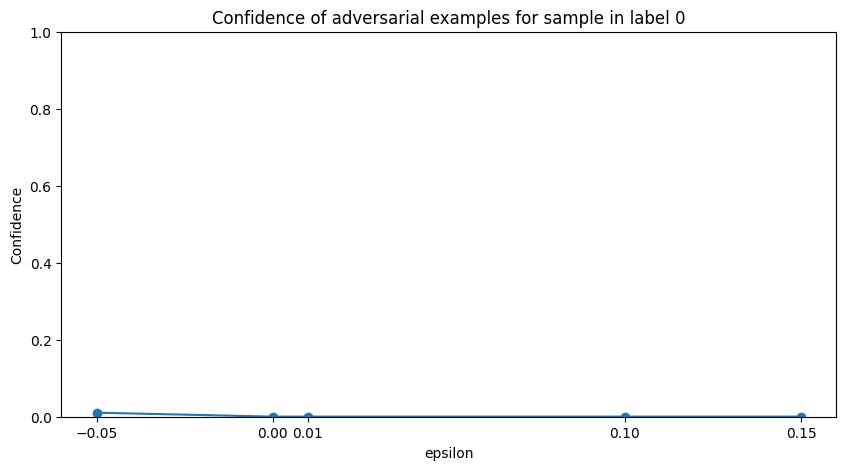

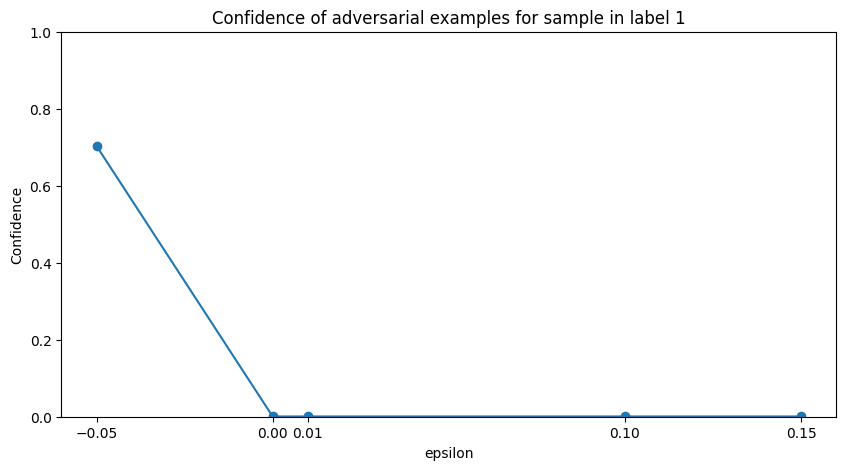

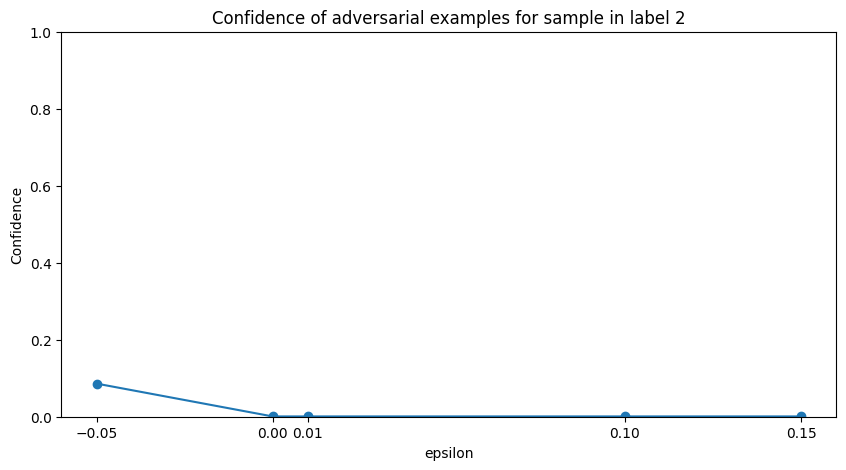

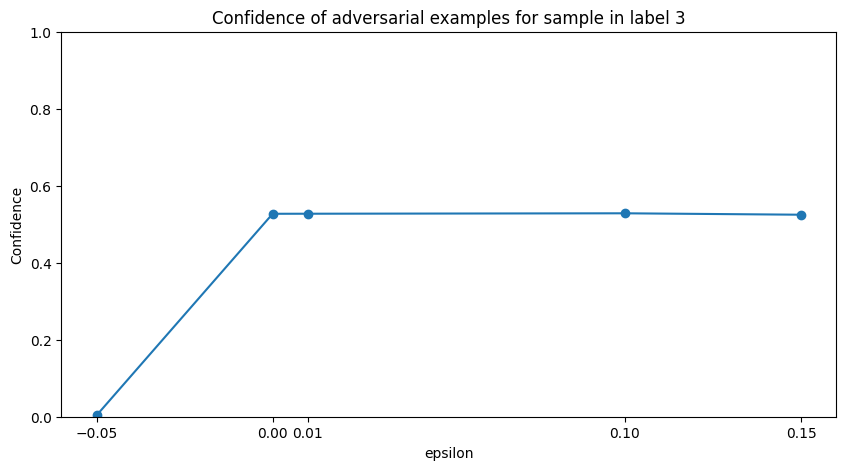

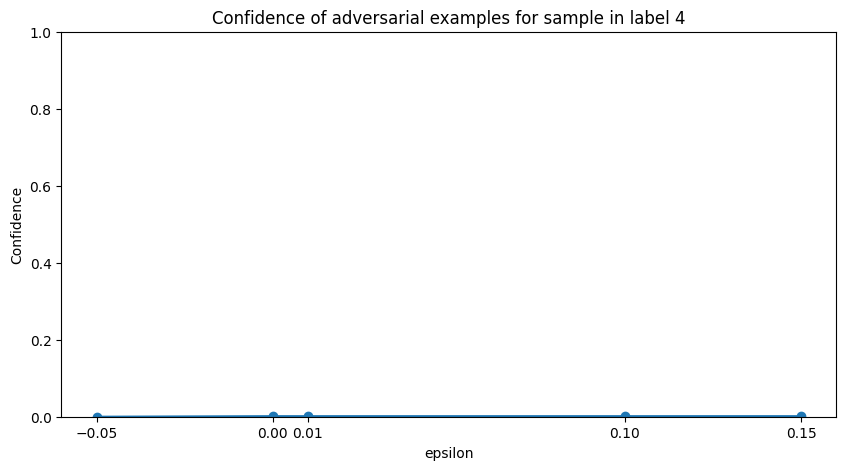

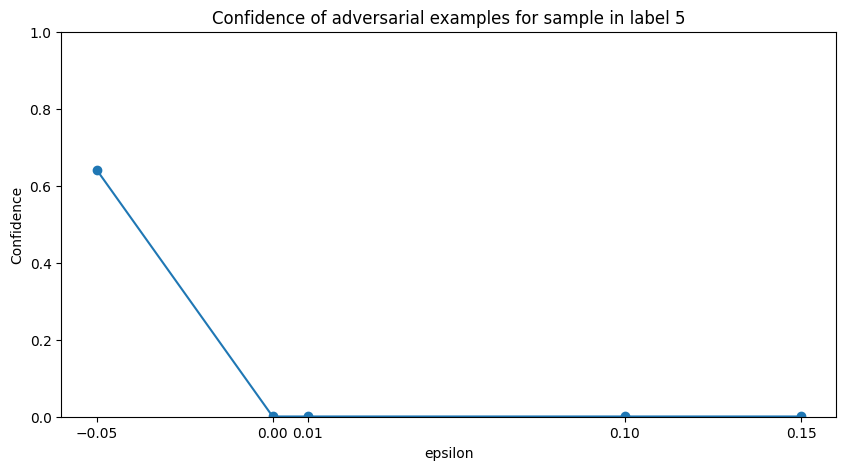

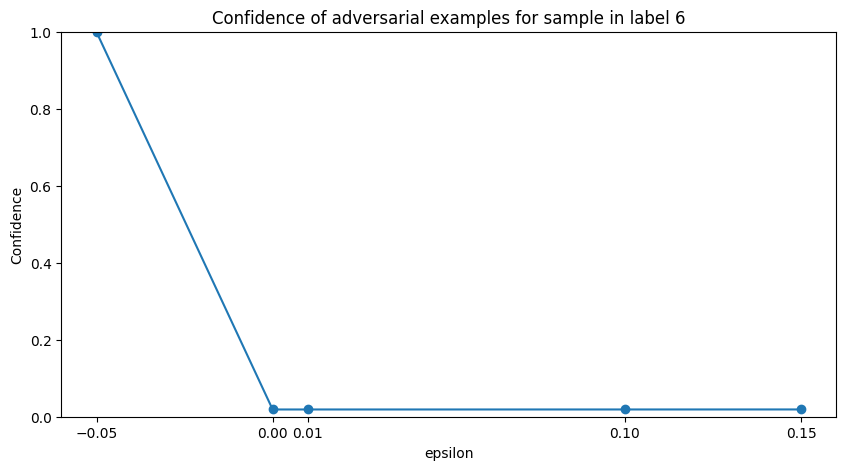

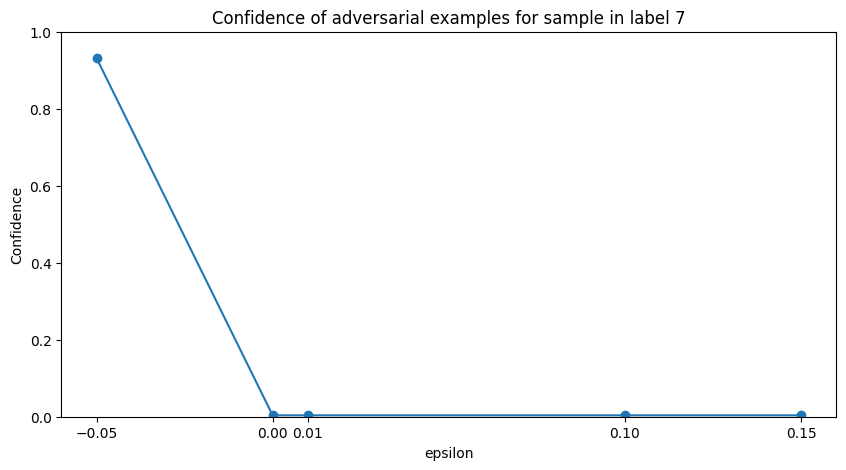

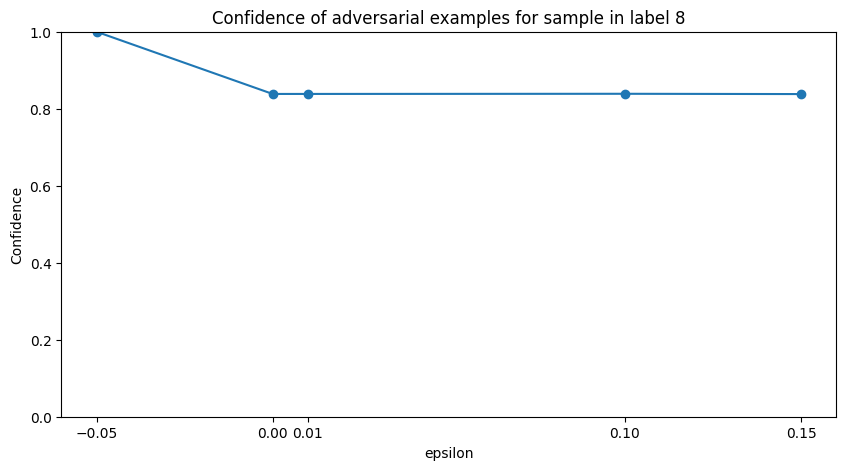

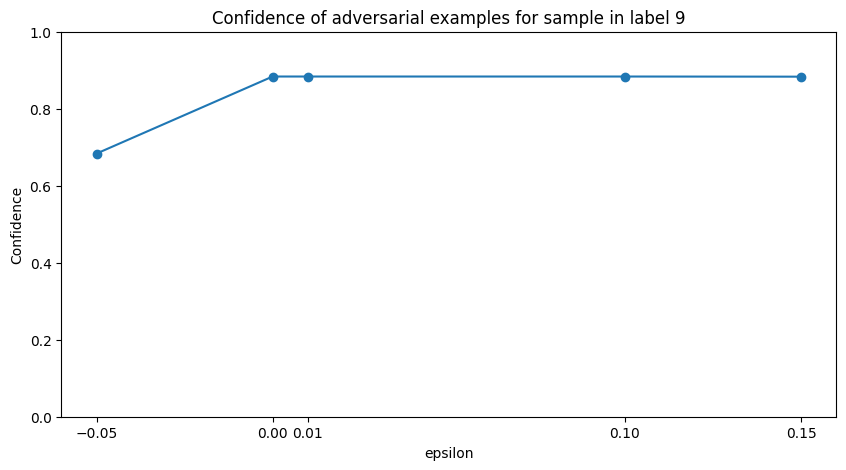

In [ ]:
# Carregar os dados preprocessados e modelo
X_train, y_train, X_test, y_test, X_val, y_val = preprocess_dataset('dataset_cnn.pkl', [0, 1, 2, 3, 4, 5, 6, 7], [8], [9])
model = load_model("cnn_batchNorm.h5")

# Mapeamento de classes 
class_mapping = {'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2,
                 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5,
                 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}

X_test_subset = []
y_test_subset = []

for label in class_mapping.values():
    
    indices = np.where(y_test == label)[0]
    selected_index = np.random.choice(indices)
    X_test_subset.append(X_test[selected_index])
    y_test_subset.append(y_test[selected_index])

X_test_subset = np.array(X_test_subset)
y_test_subset = np.array(y_test_subset)

confidences = deepfool_attack(model, X_test_subset, y_test_subset, epsilon=0.01)

plot_confidences(confidences, y_test_subset)

A partir dos níveis de confiança observados para as diferentes classes, podemos concluir que a robustez do modelo na sua generalidade não é muito boa, uma vez que o modelo só consegue classificar com uma confiança alta 2 dos 10 tipos de sons do dataset.